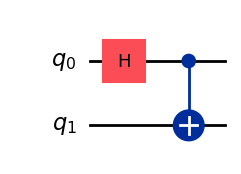

In [1]:
##### Do the Hello World Example using the 2-qubit bell state #####

# Step 1: Map the problem into circuits and operators

from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw(output='mpl')

In [2]:
from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('II')

observables = [ZZ, ZI, IZ, XX, XI, IX]

In [3]:
# Step 2 : Optimize (but we use qiskit aer so no need)

# Step 3 : Execute on the backend

from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc] * len(observables), observables)

job.result()


EstimatorResult(values=array([1.        , 0.06640625, 0.06640625, 1.        , 0.046875  ,
       1.        ]), metadata=[{'shots': 1024, 'variance': 0.0, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0034462, 'sample_measure_time': 0.0011325, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 16070, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 16, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False}}]}, {'shots': 1024, 'variance': 0.9955902099609375, 'simulator_metadata': [{'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0034462, 'sample_measure_time': 0.0011325, '

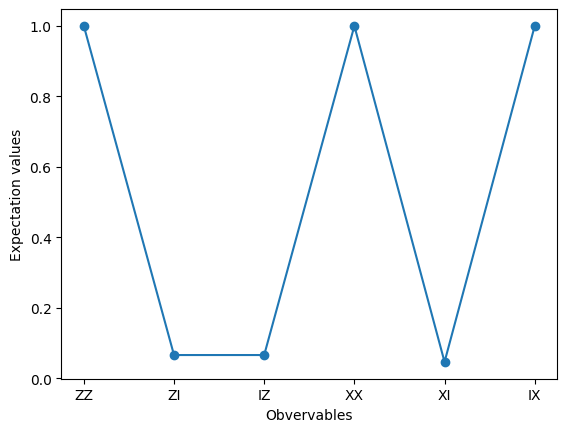

In [ ]:
# Step 4 : Post-process (and plotting)

import matplotlib.pyplot as plt

# I - identity : does nothing
# X - Bit-flip : like NOT gate
# Z - phase-flip : flip if qubit = 1
# Y - Combined bit + phase flip

# Eg if ZZ means apply Z on both qubits
# Eg if ZI means apply on qubit 0 and I (do nothing) on qubit 1

data = ['ZZ', 'ZI', 'IZ', 'XX', 'XI', 'IX']
values = job.result().values

plt.plot(data, values, '-o')
plt.xlabel('Obvervables')
plt.ylabel('Expectation values')
plt.show()

# basically the jon is to see what happens I measure both qubits in the same direction
# as seen in the graph ZZ and XX are perfectly 1.0
# kalau dia nda entangled then reading one of them are lower gitu

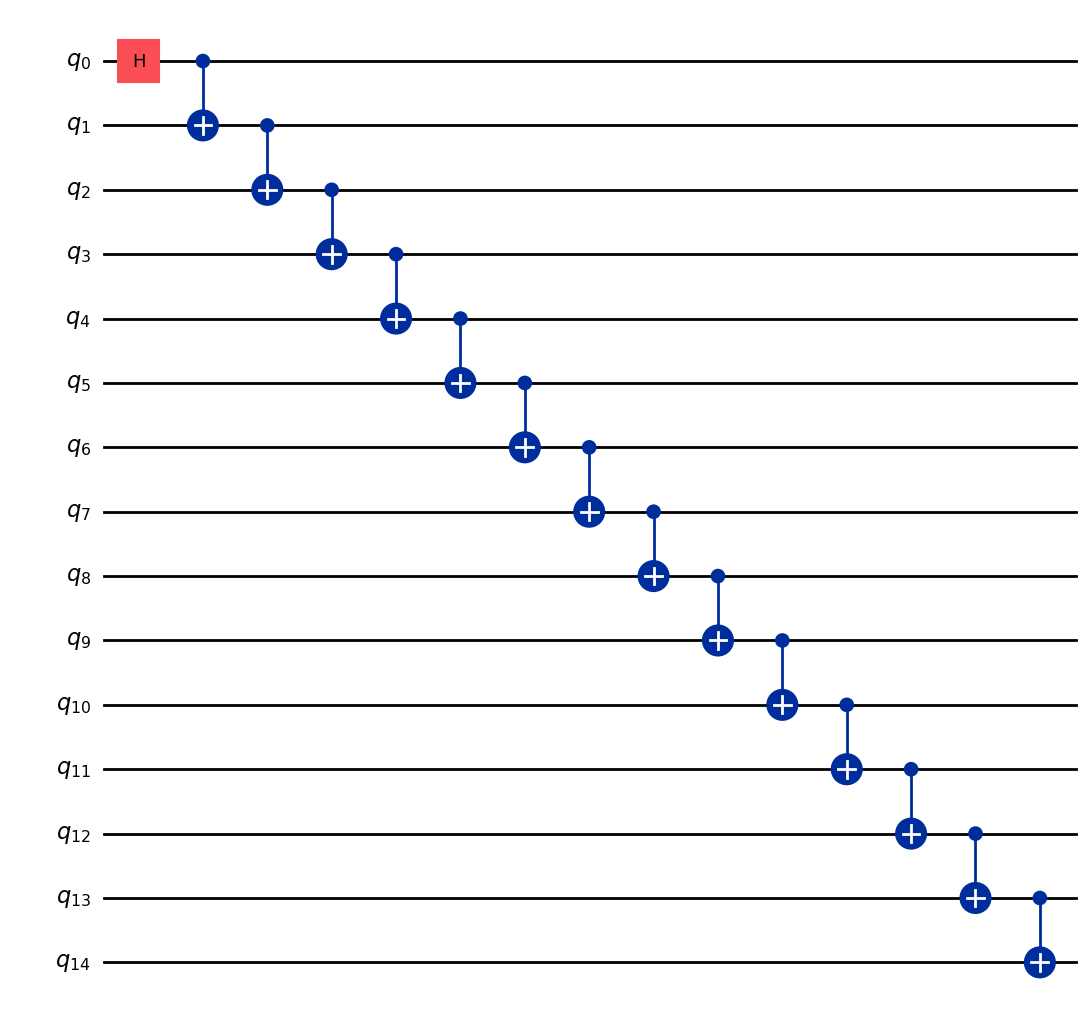

In [14]:
# Extend the Hellow World example to an n-qubit GHZ state

def get_qc_for_n_qubit_GHZ_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range (n-1):
        qc.cx(i, i+1)
    return qc

n = 15
qc = get_qc_for_n_qubit_GHZ_state(n)
qc.draw(output='mpl')

# Next need to see how the values are corrupted by noise as distance increases

In [15]:
from qiskit.quantum_info import SparsePauliOp

'''
For each i in the range 0 to n-2:
You’re creating a string with:
# A Z gate on qubit i
# A bunch of I (identity = do nothing)
# Another Z gate on qubit i+1
# Then more I gates to pad it to total length n

'''
# convert your strings like 'IZZI' into real Pauli operators that Qiskit can work with
#  — specifically in a sparse format for efficiency.
# Basically here is to improve efficiency gitu

operator_strings = ['Z' + 'I' *  i + 'Z' + 'I' * (n-2-i) for i in range(n-1) ]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]

# 10 total qubits in this case

['ZZIIIIIIIIIIIII', 'ZIZIIIIIIIIIIII', 'ZIIZIIIIIIIIIII', 'ZIIIZIIIIIIIIII', 'ZIIIIZIIIIIIIII', 'ZIIIIIZIIIIIIII', 'ZIIIIIIZIIIIIII', 'ZIIIIIIIZIIIIII', 'ZIIIIIIIIZIIIII', 'ZIIIIIIIIIZIIII', 'ZIIIIIIIIIIZIII', 'ZIIIIIIIIIIIZII', 'ZIIIIIIIIIIIIZI', 'ZIIIIIIIIIIIIIZ']
14


In [ ]:
# Step 2 : Optimize the problem for quantum execution

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Transpilation is a process of rearranging circuit gates so they fit the hardware constrains
backend_name = "ibm_brisbane"
backend = QiskitRuntimeService().get_backend(backend_name)
pass_Manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_Manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

AccountNotFoundError: 'Unable to find account.'

In [ ]:
# Step 3 : Run on backend 

from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
options.optimization_level = 0
options.dynamical_decoupling.enable= True
options.dynamical_decoupling.enable= "XY4"

estimator = Estimator(backend, options=options)

job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)

In [ ]:
# Step 4 : Post-process and plot

job_id = ''
service = QiskitRuntimeService()
job = service.job(job_id)

In [ ]:
import matplotlib.pyplot as plt

data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs
values = [v / values[0] for v in values]

plt.scatter(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle$')
plt.legend()
plt.show()